In [2]:
pip install fastapi uvicorn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.4 MB/s eta 0:00:00


In [17]:
import numpy as np
import random
from sklearn.neural_network import MLPRegressor
from collections import deque
import matplotlib.pyplot as plt
import fastapi
from fastapi import FastAPI
import uvicorn
import pickle
import os
import asyncio
import nest_asyncio

In [18]:
nest_asyncio.apply()

In [19]:
# Circuit board constraints
BOARD_WIDTH = 20  # Increased Board width in cm
BOARD_HEIGHT = 16  # Increased Board height in cm

COMPONENTS = [
    {"name": "Resistor", "width": 2, "height": 1, "color": "lightblue", "power": 0.25},
    {"name": "Capacitor", "width": 3, "height": 2, "color": "lightgreen", "power": 0.5},
    {"name": "Diode", "width": 1, "height": 1, "color": "yellow", "power": 0.2},
    {"name": "Transistor", "width": 2, "height": 2, "color": "orange", "power": 0.75},
    {"name": "IC", "width": 4, "height": 3, "color": "lightcoral", "power": 1.5},
    {"name": "Connector", "width": 3, "height": 1, "color": "purple", "power": 0.3}
]

In [20]:

# Define the environment for PCB placement
class PCBEnv:
    def __init__(self):
        self.board_size = (BOARD_HEIGHT, BOARD_WIDTH)
        self.num_components = len(COMPONENTS)
        self.reset()

    def reset(self):
        self.board = np.zeros(self.board_size)  # 0 means empty space
        self.placed_components = []
        self.current_component = 0
        return self.board.flatten()

    def step(self, action):
        row, col = divmod(action, self.board_size[1])
        component = COMPONENTS[self.current_component]
        width, height = component["width"], component["height"]

        if row + height <= BOARD_HEIGHT and col + width <= BOARD_WIDTH and np.all(self.board[row:row+height, col:col+width] == 0):
            self.board[row:row+height, col:col+width] = 1  # Place component
            self.placed_components.append((row, col, width, height))
            self.current_component += 1
            reward = 1
        else:
            reward = -1  # Penalize invalid placements

        done = self.current_component >= self.num_components
        return self.board.flatten(), reward, done, {}

    def get_valid_actions(self):
        return [i for i in range(self.board_size[0] * self.board_size[1]) if self.board.flatten()[i] == 0]

    def render(self):
        fig, ax = plt.subplots()
        ax.set_xlim(0, BOARD_WIDTH)
        ax.set_ylim(0, BOARD_HEIGHT)
        for x, y, w, h in self.placed_components:
            rect = plt.Rectangle((y, BOARD_HEIGHT - x - h), w, h, edgecolor='black', facecolor='gray')
            ax.add_patch(rect)
        plt.grid()
        plt.title("PCB Component Layout")
        plt.show()

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = MLPRegressor(hidden_layer_sizes=(64, 64), activation='relu', solver='adam', learning_rate_init=0.01, max_iter=1, warm_start=True)
        self.model.fit(np.zeros((1, state_size)), np.zeros((1, action_size)))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice(range(self.action_size))
        q_values = self.model.predict(np.array([state]))
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        X_train, y_train = [], []
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(np.array([next_state]))[0])
            q_values = self.model.predict(np.array([state]))[0]
            q_values[action] = target
            X_train.append(state)
            y_train.append(q_values)
        self.model.fit(np.array(X_train), np.array(y_train))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [21]:
# Training the model
env = PCBEnv()
state_size = env.board_size[0] * env.board_size[1]
action_size = state_size
agent = DQNAgent(state_size, action_size)

episodes = 1000
for e in range(episodes):
    state = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
    agent.replay()

    if e % 100 == 0:
        print(f"Episode {e}, Epsilon: {agent.epsilon:.3f}")

# Save model
model_path = "pcb_placement_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(agent.model, f)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691

Episode 0, Epsilon: 1.000


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691

Episode 100, Epsilon: 0.612
Episode 200, Epsilon: 0.371
Episode 300, Epsilon: 0.225
Episode 400, Epsilon: 0.136
Episode 500, Epsilon: 0.082
Episode 600, Epsilon: 0.050
Episode 700, Epsilon: 0.030
Episode 800, Epsilon: 0.018
Episode 900, Epsilon: 0.011


In [22]:
def optimize_layout():
    # Example: Generate random positions for each component
    best_layout = []
    for component in COMPONENTS:
        x = random.randint(0, BOARD_WIDTH - component["width"])
        y = random.randint(0, BOARD_HEIGHT - component["height"])
        best_layout.extend([x, y])
    return best_layout

Best Layout: [0, 3, 11, 14, 17, 5, 1, 14, 3, 6, 10, 13]


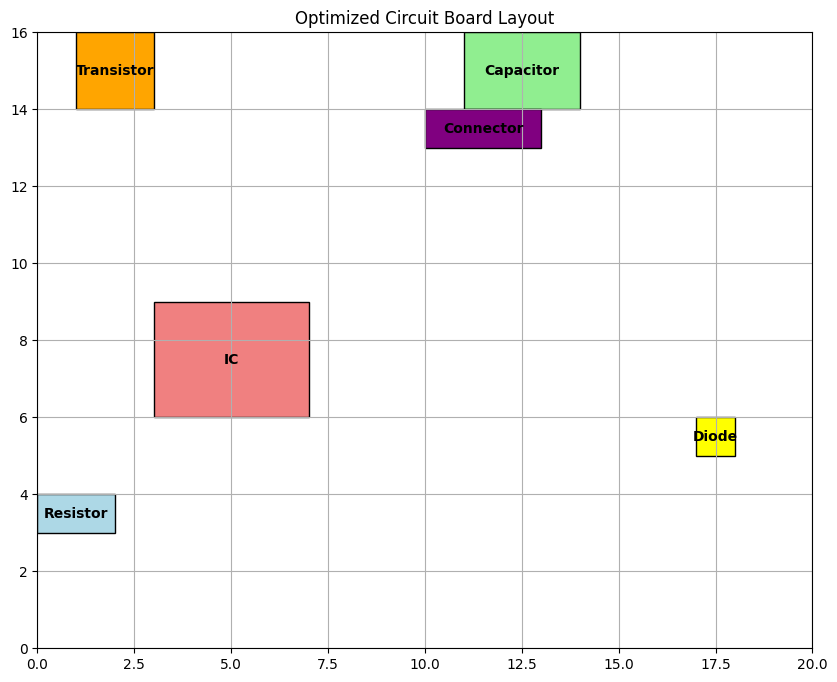

In [68]:
if __name__ == "__main__":
    best_layout = optimize_layout()
    print("Best Layout:", best_layout)  # Debugging output
    plot_layout(best_layout)

In [35]:
!pip install fastapi uvicorn nest_asyncio pyngrok

In [69]:
!pip install fastapi uvicorn nest_asyncio pyngrok requests

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pkill -f ngrok

In [3]:
!ngrok authtoken 2k6ZothRfWW90Npy1sucVSPROcB_4uVcsxBr5TSngdCxk45q

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [4]:
# Import required libraries
from fastapi import FastAPI
from fastapi.responses import FileResponse
import uvicorn
import nest_asyncio
from pyngrok import ngrok
import os

# Stop previous ngrok tunnels (prevents errors)
ngrok.kill()

# Initialize FastAPI app
app = FastAPI()

# Route to check if API is running
@app.get("/")
def home():
    return {"message": "FastAPI is running successfully in Google Colab!"}

# Route to serve the image
@app.get("/image")
def get_image():
    image_path = "circuit_layout.png"  # Ensure this file exists
    if os.path.exists(image_path):
        return FileResponse(image_path, media_type="image/png")
    return {"error": "Image not found!"}

# Apply nest_asyncio to prevent Colab runtime issues
nest_asyncio.apply()

# Start a new ngrok tunnel
public_url = ngrok.connect(8000).public_url
print(f"🚀 Public URL: {public_url}")

# Start Uvicorn server
uvicorn.run(app, host="0.0.0.0", port=8000)

INFO:     Started server process [27551]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


🚀 Public URL: https://5a8e-35-234-12-91.ngrok-free.app
INFO:     103.174.111.87:0 - "GET / HTTP/1.1" 200 OK
INFO:     103.174.111.87:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     103.174.111.87:0 - "GET / HTTP/1.1" 200 OK
INFO:     103.174.111.87:0 - "GET /image HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [27551]


In [11]:
# Import required libraries
from fastapi import FastAPI
from fastapi.responses import FileResponse
import uvicorn
import nest_asyncio
from pyngrok import ngrok
import os
import requests
from PIL import Image
from io import BytesIO

# Stop any process running on port 8000 (Fixes Address Already in Use)
os.system("fuser -k 8000/tcp")

# Initialize FastAPI app
app = FastAPI()

# Route to check if API is running
@app.get("/")
def home():
    return {"message": "FastAPI is running successfully in Google Colab!"}

# Route to serve an image file
@app.get("/image")
def get_image():
    image_path = "circuit_layout.png"  # Ensure this file exists
    if os.path.exists(image_path):
        return FileResponse(image_path, media_type="image/png")
    return {"error": "Image not found!"}

# Route to fetch an image from a URL and display it
@app.get("/fetch_image")
def fetch_image(image_url: str):
    try:
        response = requests.get(image_url, stream=True)
        response.raise_for_status()  # Raise an error if request fails

        # Load image correctly to prevent UnidentifiedImageError
        img = Image.open(BytesIO(response.content))
        img.show()  # Display the image

        return {"message": "Image fetched and displayed successfully"}
    except requests.exceptions.RequestException as e:
        return {"error": f"Request failed: {e}"}
    except Exception as e:
        return {"error": f"Image processing failed: {e}"}

# Apply nest_asyncio to prevent Colab runtime issues
nest_asyncio.apply()

# Start a new ngrok tunnel
public_url = ngrok.connect(8000).public_url
print(f"🚀 Public URL: {public_url}")

# Start Uvicorn server
uvicorn.run(app, host="0.0.0.0", port=8000)

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-17' coro=<Server.serve() done, defined at /usr/local/lib/python3.11/dist-packages/uvicorn/server.py:68> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/main.py", line 579, in run
    server.run()
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/server.py", line 66, in run
    return asyncio.run(self.serve(sockets=sockets))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
    s

🚀 Public URL: https://279f-35-234-12-91.ngrok-free.app


INFO:     Started server process [27551]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     103.174.111.87:0 - "GET / HTTP/1.1" 200 OK
INFO:     103.174.111.87:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [27551]


In [6]:
import os
print(os.path.exists("circuit_layout.png"))  # Should return True

True


In [12]:
!pip install fastapi uvicorn pyngrok nest-asyncio

In [14]:
!pip install fastapi uvicorn pyngrok nest-asyncio

from fastapi import FastAPI
from pydantic import BaseModel
import uvicorn
import threading
from pyngrok import ngrok
import nest_asyncio
import time

# Initialize FastAPI app
app = FastAPI()

# Define input schema
class InputData(BaseModel):
    feature1: float
    feature2: float

# Dummy model function (Replace with actual ML model)
def model_predict(feature1, feature2):
    return feature1 + feature2  # Example logic

@app.post("/predict")
def predict(data: InputData):
    prediction = model_predict(data.feature1, data.feature2)
    return {"prediction": prediction}

# Allow FastAPI to run inside Colab
nest_asyncio.apply()

# Start FastAPI server in the background
def run():
    uvicorn.run(app, host="0.0.0.0", port=8000)

thread = threading.Thread(target=run)
thread.start()

# Wait for FastAPI to start
time.sleep(5)

# Create a public URL using Ngrok
public_url = ngrok.connect(8000)
print("🚀 Public URL:", public_url)

INFO:     Started server process [27551]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
ERROR:    [Errno 98] error while attempting to bind on address ('0.0.0.0', 8000): address already in use
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.


🚀 Public URL: NgrokTunnel: "https://a6fe-35-234-12-91.ngrok-free.app" -> "http://localhost:8000"
